In [1]:
from eagergradcamtf import grad_cam

In [1]:
import tensorflow as tf

In [2]:
from PIL import Image

In [16]:
with open('model_partfreeze0.1.json', 'r') as f:
    model_init = tf.keras.models.model_from_json(f.read())
model_init.load_weights('weights_partfreeze0.2.h5')

In [17]:
y = model_init.get_layer(model_init.layers[-4].name).output
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(1, activation=None, name='output_dense')(y) # activation none for Grad-CAM
model = tf.keras.models.Model(inputs=model_init.input, outputs=y)

In [18]:
im = Image.open('locked/img1.jpg')

In [21]:
%matplotlib inline

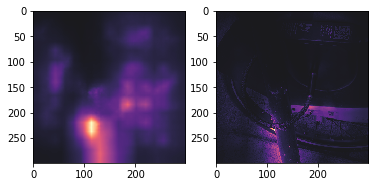

In [22]:
grad_cam('locked/img1.jpg', model, (299,299))

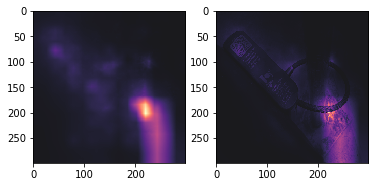

In [23]:
grad_cam('locked/img4.jpg', model, (299,299))  #hopeful

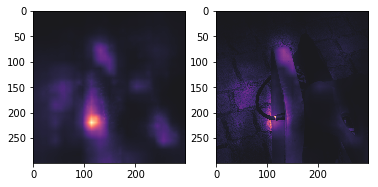

In [24]:
grad_cam('locked/img5.jpg', model, (299,299))  #hopeless

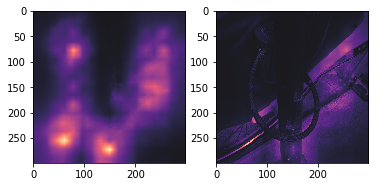

In [25]:
grad_cam('locked/img9.jpg', model, (299,299))  #hopeful

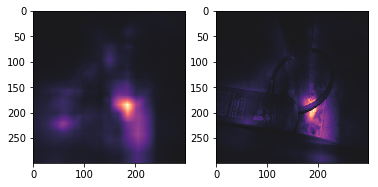

In [26]:
grad_cam('locked/img11.jpg', model, (299,299))  # hopeful

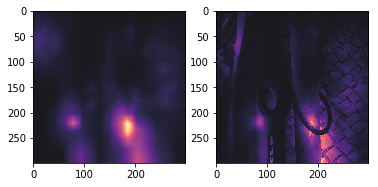

In [27]:
grad_cam('locked/img18.jpg', model, (299,299))  #hopeful

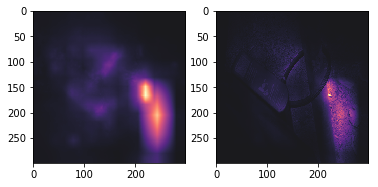

In [28]:
grad_cam('locked/img21.jpg', model, (299,299))  #hopeful

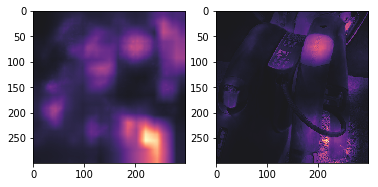

In [29]:
grad_cam('locked/img22.jpg', model, (299,299))  #hopeful

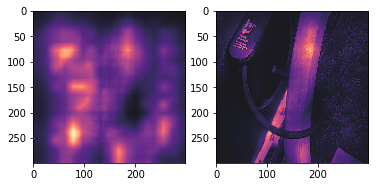

In [30]:
grad_cam('locked/img24.jpg', model, (299,299))  #hopeful

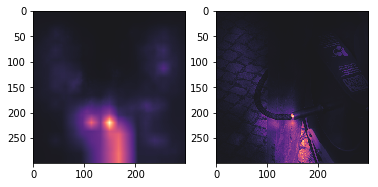

In [31]:
grad_cam('locked/img26.jpg', model, (299,299))  #hopeless

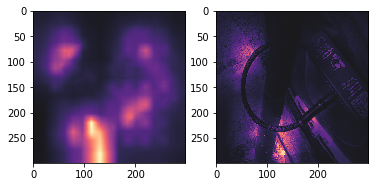

In [42]:
grad_cam('locked/img29.jpg', model, (299,299))  #hopeful

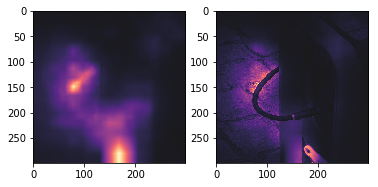

In [41]:
grad_cam('locked/img40.jpg', model, (299,299))  #hopeless

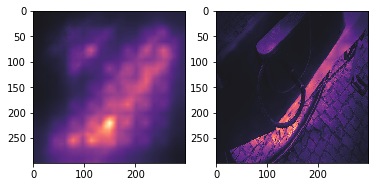

In [34]:
grad_cam('freelocked/img0-kopia.jpg', model, (299,299))  #hopeful

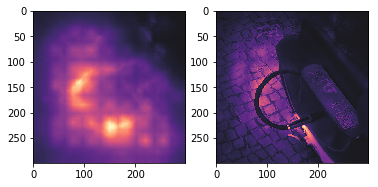

In [35]:
grad_cam('freelocked/img1-kopia.jpg', model, (299,299))  #hopeful

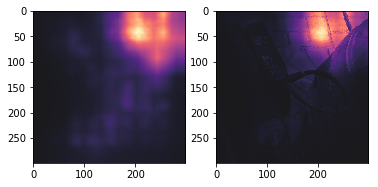

In [36]:
grad_cam('freelocked/img13.jpg', model, (299,299))  #hopeless

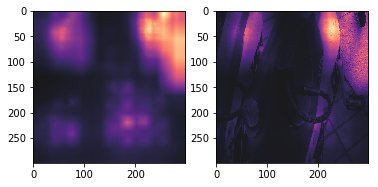

In [37]:
grad_cam('freelocked/img14-kopia.jpg', model, (299,299))  #hopeless

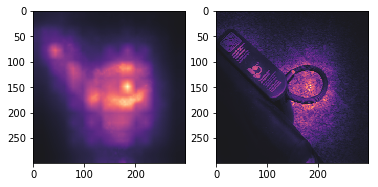

In [38]:
grad_cam('freelocked/img15.jpg', model, (299,299))  #hopeful

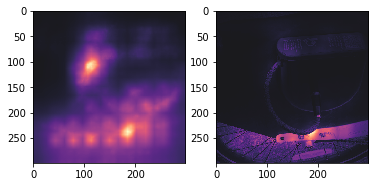

In [39]:
grad_cam('freelocked/img27.jpg', model, (299,299))  #hopeful

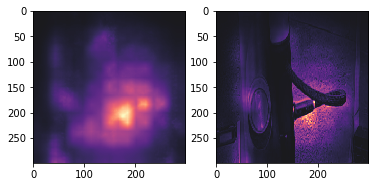

In [40]:
grad_cam('freelocked/img30.jpg', model, (299,299))  #very hopeful

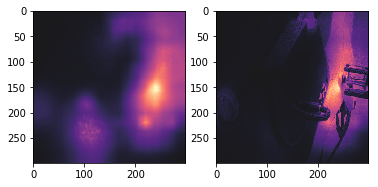

In [60]:
grad_cam('freelocked/img35.jpg', model, (299,299))  #hopeless

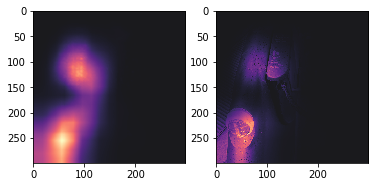

In [61]:
grad_cam('freelocked/img38.jpg', model, (299,299))  #hopeless

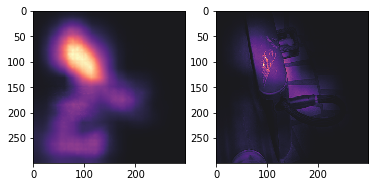

In [62]:
grad_cam('freelocked/img69.jpg', model, (299,299))  #hopeful

In [4]:
from tensorflow.keras.applications import ResNet50

In [5]:
model_init = ResNet50(include_top=True)

In [6]:
y = model_init.get_layer(model_init.layers[-2].name).output
# y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(1000, activation='linear', name='fc1000')(y) # activation none for Grad-CAM
model = tf.keras.models.Model(inputs=model_init.input, outputs=y)

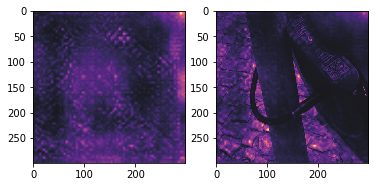

In [8]:
grad_cam('locked/img162.jpg', model, (299,299), watch_layer_instances=(tf.keras.layers.Conv2D, tf.keras.layers.SeparableConv2D))

In [8]:
from lime import lime_image

In [9]:
from skimage.segmentation import mark_boundaries

In [12]:
import matplotlib.pyplot as plt

In [10]:
import numpy as np

In [14]:
explainer = lime_image.LimeImageExplainer()

# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(np.array(im), model.predict, top_labels=2, hide_color=0, num_samples=1000)

/Users/kjczarne/anaconda3/envs/fubarenv/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=2.03655e-18): result may not be accurate.
  overwrite_a=False)


W0615 16:03:08.223984 4656330176 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


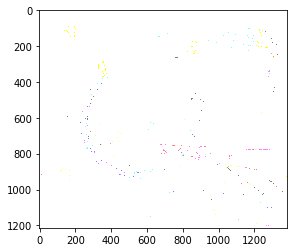

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [76]:
def load_byte_img(im_bytes):
        buf = BytesIO(im_bytes)
        im = np.array(Image.open(buf).resize((299, 299)), dtype=np.float64) / 255.
        return np.expand_dims(im, axis=0)

def custom_predict(examples_to_infer, model):

    ims = [load_byte_img(ex.features.feature['image/encoded'].bytes_list.value[0]) 
         for ex in examples_to_infer]
    preds = model.predict(np.array(ims))
    return preds

In [77]:
load_byte_img(byte_im[0].features.feature['image/encoded'].bytes_list.value[0]).shape

(1, 299, 299, 3)

In [78]:
model_init.predict(load_byte_img(byte_im[0].features.feature['image/encoded'].bytes_list.value[0]))

array([[0.]], dtype=float32)

In [42]:
def tf_example_generator(paths_dataframe, x_col='x_col', y_col='y_col'):
    """
    A helper function generating tf.Example instances from input data
    :param paths_dataframe: pd.DataFrame as returned by custom file_train_test_split function
    :param x_col: string specifying the column with pathname
    :param y_col: string specifying the column with labels
    :return: list of tf.Example objects
    """
    examples = []
    unique_labels = set(paths_dataframe[y_col])
    dict_mapping = dict()
    for i in zip(list(unique_labels), range(len(unique_labels))):
        dict_mapping[i[0]] = i[1]
    labels = []
    for i in paths_dataframe[y_col]:
        labels.append(dict_mapping[i])
    for i in paths_dataframe[x_col]:
        example = tf.train.Example()
        with open(i, 'rb') as f:
            im = Image.open(f)
            buffer = BytesIO()
            im.save(buffer, format='JPEG')
            image_bytes = buffer.getvalue()
            example.features.feature['image/encoded'].bytes_list.value.append(image_bytes)
        examples.append(example)
    return examples, labels

In [7]:

# write test set as a TFRecord
def write_tfrecord(test_dataframe, x_col='x_col', y_col='y_col', outfile='TFRecord/images.tfrecord'):
    labels = test_dataframe[y_col]
    images = test_dataframe[x_col]
    for label, image in zip(labels, images):
        with open(image, 'rb') as f:
            im = Image.open(f)
        feature = {
          'test/label':tf._bytes_feature(label),
          'test/image':tf._bytes_feature(im)
        }

    example = tf.train.Example(
        features = tf.train.Features(feature=feature)
    )
    with tf.python_io.TFRecordWriter(outfile) as writer:
        for example in examples:
            writer.write(example.SerializeToString())
    

In [45]:
import glob

In [54]:
import os

In [71]:
def get_fresh_weights_and_model(directory, globstring_model, globstring_weights):
    model_names = glob.glob(directory + '/' + globstring_model) 
    model_names.sort(reverse=True)
    weight_names = glob.glob(directory + '/' + globstring_weights)
    weight_names.sort(reverse=True)
    return model_names[0], weight_names[0]

In [72]:
get_fresh_weights_and_model(os.getcwd(), 'model_partfreeze*', 'weights_partfreeze*')

('/Users/kjczarne/Desktop/Coding/Python/DSR/fubar/model_partfreeze0.4.json',
 '/Users/kjczarne/Desktop/Coding/Python/DSR/fubar/weights_partfreeze0.2.h5')

In [10]:
from cnn_toolkit import file_train_test_split

In [12]:
from pathlib import Path

In [14]:
paths = file_train_test_split(Path('/Users/kjczarne/Downloads/FubarArchive'), fmt=['jpg'], ignored_directories=['diaosd'])

In [ ]:
write_tfrecord

In [44]:
paths[1].loc[0:2]

,y_col,x_col
0,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
1,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...
2,locked,/home/ubuntu/darknet/AlexeyAB/darknet/result_i...


In [48]:
byte_im = tf_example_generator(paths[1].loc[0:1])[0]

In [6]:
from PIL import Image

In [8]:
im = Image.open('FubarArchive/Locked_Loop/image (5).png')

In [9]:
im2 = Image.open('FubarArchive/Locked_Loop/image (5).png')

In [13]:
np.isclose(np.array(im), np.array(im2)).all()

True

In [19]:
im2 = Image.open('FubarArchive/Locked_Loop/Image from iOS (12).jpg')

In [20]:
np.isclose(np.array(im), np.array(im2)).all()

ValueError: operands could not be broadcast together with shapes (3024,4032,4) (1334,750,3) 

In [4]:
base = tf.keras.applications.InceptionV3(include_top=False)

In [5]:
y = base.get_layer(base.layers[-1].name).output
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='output_dense')(y) # activation none for Grad-CAM
model = tf.keras.models.Model(inputs=base.input, outputs=y)

In [8]:
model_struct_json = model.to_json()

with open('model_sexytest.json', 'w') as f:
    f.write(model_struct_json)

# export weights to an hdf5 file:

model.save_weights('weights_sexytest.h5')